In [2]:
import numpy as np 
import pandas as pd 

btc_data = pd.read_csv("assets/BTCUSDT.csv").drop("Unnamed: 0",axis=1)

In [3]:
from datetime import datetime


date = [datetime.utcfromtimestamp(btc_data["Open time"][X]//1000).strftime('%Y-%m-%d_%H:%M:%S') for X in range(len(btc_data))]

btc_data["Date"]=date

In [4]:
btc_data = btc_data[['Open time',"Date", 'Open', 'High', 'Low', 'Close',"Volume"]]

btc_data

,Open time,Date,Open,High,Low,Close,Volume
0,1514678400000,2017-12-31_00:00:00,12345.10,12397.16,12337.60,12347.99,6.884066
1,1514678460000,2017-12-31_00:01:00,12337.60,12348.00,12300.07,12300.14,3.302100
2,1514678520000,2017-12-31_00:02:00,12302.32,12337.19,12299.98,12311.15,8.647718
3,1514678580000,2017-12-31_00:03:00,12311.12,12345.84,12311.00,12329.76,5.375271
4,1514678640000,2017-12-31_00:04:00,12319.28,12341.45,12287.89,12311.02,12.270461
...,...,...,...,...,...,...,...
2243607,1649773920000,2022-04-12_14:32:00,39893.26,39916.42,39878.76,39910.00,41.412350
2243608,1649773980000,2022-04-12_14:33:00,39909.99,39933.52,39905.32,39908.10,34.018590
2243609,1649774040000,2022-04-12_14:34:00,39908.10,39970.00,39908.10,39957.97,33.642590
2243610,1649774100000,2022-04-12_14:35:00,39957.96,40064.08,39957.96,40026.96,167.133340


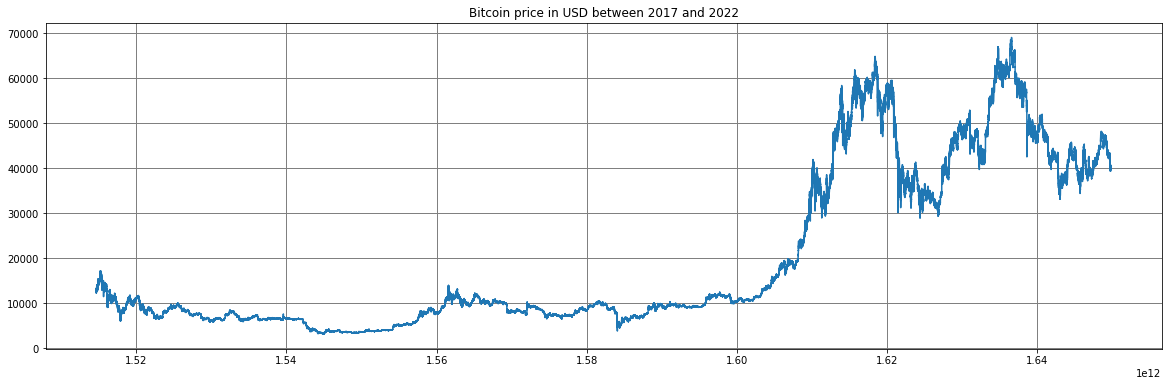

In [5]:
import matplotlib.pyplot as plt 

X = btc_data["Open time"] 
Y = btc_data.Close

plt.figure(figsize=(20,6))
plt.plot(X,Y) 
plt.title("Bitcoin price in USD between 2017 and 2022")
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.show()

# Create different timeframes 

In [6]:
minutes = [5,15,60,240,24*60]
names = ["5min","15min","1h","4h","1d"]

for minute,name in zip(minutes,names): 
    data_list = []
    for i in range(0,len(btc_data),minute): 
        open_time = btc_data["Open time"][i]
        date = btc_data["Date"][i]
        open_price = btc_data["Open"][i]
        close_price = btc_data["Close"][int(min(i+minute,len(btc_data)-1))]
        high_price = max(btc_data["High"][i:int(min(i+minute,len(btc_data)-1))])
        low_price = min(btc_data["Low"][i:int(min(i+minute,len(btc_data)-1))])
        volume = sum(btc_data["Volume"][i:int(min(i+minute,len(btc_data)-1))])
        data_list.append([open_time,date,open_price,high_price,low_price,close_price,volume])
    df = pd.DataFrame(data_list,columns = ["Open time","Date","Open","High","Low","Close","Volume"])
    df.to_csv(f"assets/BTCUSDT-{name}.csv")

# Daily volatility 



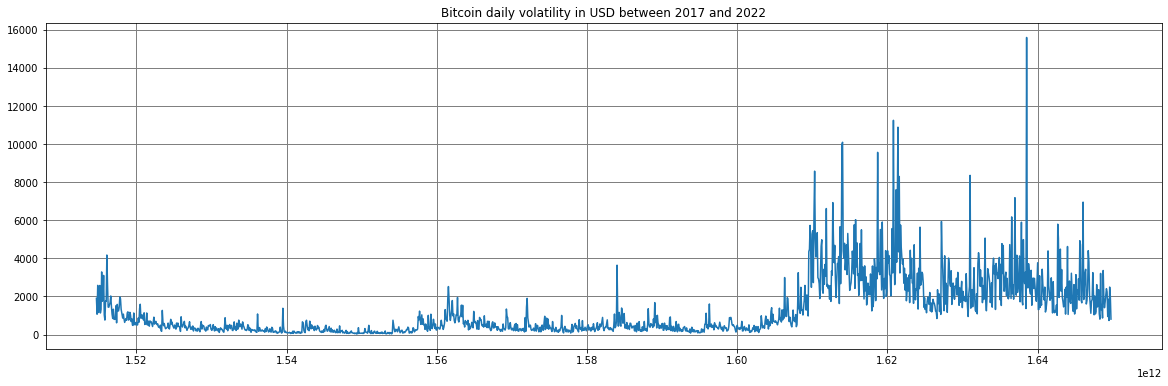

In [9]:
daily_btc_data = pd.read_csv("assets/BTCUSDT-1d.csv")

X = daily_btc_data["Open time"]
Y = daily_btc_data["High"] - daily_btc_data["Low"]

plt.figure(figsize=(20,6))
plt.plot(X,Y) 
plt.title("Bitcoin daily volatility in USD between 2017 and 2022")
plt.grid(color='gray', linestyle='-', linewidth=1)
plt.show()


# RNN without feature engineering : 
## 1. Creating the labels : 

We want to predict 1 timeframe in the future by reading 12 time frames in the past : 

In [16]:
hourly_btc_data = pd.read_csv("assets/BTCUSDT-1h.csv").drop("Unnamed: 0",axis=1)

In [17]:
hourly_btc_data["Target"] = [-1 if i>len(hourly_btc_data)-2 else ( 0 if hourly_btc_data.Close[i]>hourly_btc_data.Close[i+1] else 1) for i in range(len(hourly_btc_data))]

hourly_btc_data = hourly_btc_data.loc[(hourly_btc_data.Target!=-1)]

hourly_btc_data.head()

,Open time,Date,Open,High,Low,Close,Volume,Target
0,1514678400000,2017-12-31_00:00:00,12345.10,12897.00,12149.98,12860.00,729.979678,1
1,1514682000000,2017-12-31_01:00:00,12850.00,13141.00,12511.00,12905.02,677.240114,1
2,1514685600000,2017-12-31_02:00:00,12957.15,13400.00,12850.01,13321.63,657.491611,0
3,1514689200000,2017-12-31_03:00:00,13350.00,13411.02,12850.01,13031.66,637.002697,0
4,1514692800000,2017-12-31_04:00:00,12988.04,13037.27,12755.00,12930.00,511.788737,0


## 2. Scaling the data

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaled_hourly_btc_data = pd.DataFrame()

scaled_hourly_btc_data["Open time"] = hourly_btc_data["Open time"]
scaled_hourly_btc_data["Date"] = hourly_btc_data["Date"]

for col in ["Open","High","Low","Close","Volume"]:
    scaler = MinMaxScaler()
    serie = np.array(hourly_btc_data[col]).reshape(-1, 1)
    scaler.fit(serie)
    scaled_hourly_btc_data[col]  = scaler.transform(serie)

scaled_hourly_btc_data["Target"] = hourly_btc_data["Target"]

scaled_hourly_btc_data.head()

,Open time,Date,Open,High,Low,Close,Volume,Target
0,1514678400000,2017-12-31_00:00:00,0.140057,0.147517,0.137740,0.148024,0.014739,1
1,1514682000000,2017-12-31_01:00:00,0.147766,0.151225,0.143269,0.148712,0.013675,1
2,1514685600000,2017-12-31_02:00:00,0.149403,0.155160,0.148461,0.155081,0.013276,0
3,1514689200000,2017-12-31_03:00:00,0.155402,0.155328,0.148461,0.150648,0.012862,0
4,1514692800000,2017-12-31_04:00:00,0.149874,0.149648,0.147006,0.149094,0.010334,0


## 3. Creating the sequences 



In [37]:
from collections import deque 

past_check = 12 # 12 hours

sequential_data = [] 
prev_timeframes = deque(maxlen=past_check)

for line in scaled_hourly_btc_data.values:  
    line = line[2:]
    prev_timeframes.append([n for n in line[:-1]]) 
    if len(prev_timeframes) == past_check:  
        sequential_data.append([np.array(prev_timeframes), line[-1]]) 

sequential_data[0]

[array([[0.14005658, 0.14751709, 0.13773994, 0.14802408, 0.01473942],
        [0.14776646, 0.15122466, 0.14326901, 0.14871225, 0.01367453],
        [0.14940265, 0.15516016, 0.14846099, 0.15508056, 0.01327578],
        [0.15540151, 0.1553276 , 0.14846099, 0.15064807, 0.01286207],
        [0.14987434, 0.14964849, 0.1470059 , 0.1490941 , 0.01033381],
        [0.14890469, 0.15026692, 0.14463206, 0.14525196, 0.00935437],
        [0.14471244, 0.14646864, 0.14247262, 0.14313225, 0.00941673],
        [0.14310892, 0.14651893, 0.14300345, 0.14836297, 0.00762517],
        [0.14696386, 0.1483984 , 0.14328433, 0.14375424, 0.00717059],
        [0.14321612, 0.14452368, 0.14196692, 0.1424751 , 0.00697333],
        [0.14272183, 0.14739371, 0.14285014, 0.14840898, 0.00664195],
        [0.14837726, 0.15029777, 0.14831672, 0.14900865, 0.00998276]]),
 1]

## 4. Balancing the data 

In [38]:
sells = [] 
buys = [] 

for seq, target in sequential_data:  
    if target == 0: 
        sells.append([seq, target])  
    elif target == 1:  
        buys.append([seq, target])  

min_length = min(len(buys), len(sells))

buys = buys[:min_length]
sells = sells[:min_length]

sequential_data = buys + sells 

## 5. Shuffling the data :

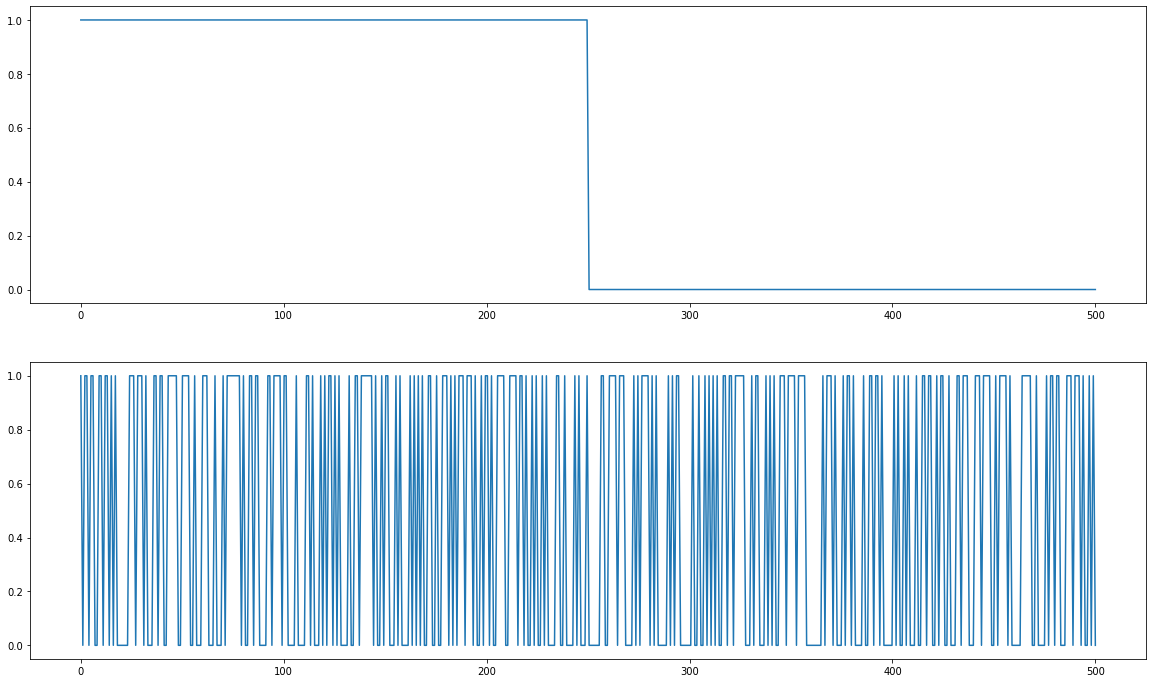

In [39]:
from sklearn.utils import shuffle

fig, ax = plt.subplots(2,1,figsize=(20,12))

x = np.linspace(0,500,500)
y = []
for _,target in sequential_data[int(len(sequential_data)/2)-250:int(len(sequential_data)/2)+250] : 
    y.append(target)

ax.flatten()[0].plot(x,y)

sequential_data = shuffle(sequential_data)
y = []
for _,target in sequential_data[int(len(sequential_data)/2)-250:int(len(sequential_data)/2)+250] : 
    y.append(target)

ax.flatten()[1].plot(x,y)

plt.show()

## 6. Train | Test Split 

In [33]:
print(f"{len(sequential_data)=}")

len(sequential_data)=36676


In [42]:
X_train = [] 
y_train = []

for seq,target in sequential_data[:int(len(sequential_data)*0.8)]:
    X_train.append(seq)
    y_train.append(target)


X_test = [] 
y_test = []

for seq,target in sequential_data[int(len(sequential_data)*0.8):]:
    X_test.append(seq)
    y_test.append(target)

X_train = np.array(X_train) 
y_train = np.array(y_train)
X_test = np.array(X_test) 
y_test = np.array(y_test)

print(f"{X_train.shape}")
print(f"{y_train.shape}")
print(f"{X_test.shape}")
print(f"{y_test.shape}")

(29340, 12, 5)
(29340,)
(7336, 12, 5)
(7336,)
